Starting threaded simulation on 64 threads...
  0.070514 seconds (237.12 k allocations: 12.648 MiB, 716.69% compilation time)
Simulation finished.
Done.


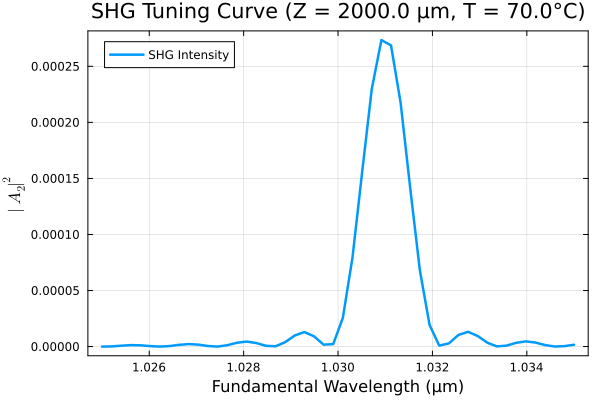

In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using Printf
using Base.Threads # スレッド機能を使うためにインポート

# --- グローバル定数と物理パラメータ ---
const KAPPA_MAG = 1.31e-5
const Z_MAX = 2000.0
const WAVELENGTH_CENTER = 1.031
const TEMP_C = 70.0

const SELLMEIER_PARAMS = (a=[4.5615, 0.08488, 0.1927, 5.5832, 8.3067, 0.021696], b=[4.782e-07, 3.0913e-08, 2.7326e-08, 1.4837e-05, 1.3647e-07])

# --- 計算関数 ---
function sellmeier_n_eff(wl::Float64, temp::Float64)
    f = (temp - 24.5) * (temp + 24.5 + 2.0 * 273.16)
    lambda_sq = wl^2
    a, b = SELLMEIER_PARAMS.a, SELLMEIER_PARAMS.b
    n_sq = (a[1] + b[1] * f + (a[2] + b[2] * f) / (lambda_sq - (a[3] + b[3] * f)^2) + (a[4] + b[4] * f) / (lambda_sq - (a[5] + b[5] * f)^2) -
            a[6] * lambda_sq)
    return sqrt(n_sq)
end

function calculate_delta_ks(wl::Float64, temp::Float64)
    wl_fw, wl_shg = wl, wl / 2.0
    n_fw, n_shg = sellmeier_n_eff(wl_fw, temp), sellmeier_n_eff(wl_shg, temp)
    delta_k1 = 2.0 * pi * (n_shg / wl_shg - 2.0 * n_fw / wl_fw)

    wl_thg = (wl_fw * wl_shg) / (wl_fw + wl_shg)
    n_thg = sellmeier_n_eff(wl_thg, temp)
    delta_k2 = 2.0 * pi * (n_thg / wl_thg - n_shg / wl_shg - n_fw / wl_fw)
    return delta_k1, delta_k2
end

const DELTA_K1_SHG_TARGET, _ = calculate_delta_ks(WAVELENGTH_CENTER, TEMP_C)

get_L(delta_k1, delta_k2) = 1im .* [0.0, delta_k1, delta_k1 + delta_k2]
A_from_B(B, z, delta_k1, delta_k2) = [B[1], B[2] * exp(-1im * delta_k1 * z), B[3] * exp(-1im * (delta_k1 + delta_k2) * z)]
phi(omega, h) = abs(omega) < 1e-9 ? h + h^2 * omega / 2.0 : (exp(omega * h) - 1.0) / omega

function predictor_ipm1(B_in, h, kappa_val, L)
    B1n, B2n, B3n = B_in
    L1, L2, L3 = L
    exp_Lh = exp.(L .* h)
    omega_a = L2 - 2 * L1
    omega_b = L3 - L2 - L1
    delta_B_NL1 = 1im * kappa_val * exp_Lh[1] * (conj(B1n) * B2n * phi(omega_a, h) + conj(B2n) * B3n * phi(omega_b, h))
    delta_B_NL2 = 1im * kappa_val * exp_Lh[2] * (B1n^2 * phi(-omega_a, h) + 2 * conj(B1n) * B3n * phi(omega_b, h))
    delta_B_NL3 = 1im * 3 * kappa_val * exp_Lh[3] * (B1n * B2n * phi(-omega_b, h))
    return (exp_Lh .* B_in) + [delta_B_NL1, delta_B_NL2, delta_B_NL3]
end

function calculate_shg_for_wavelength(wavelength::Float64)
    delta_k1, delta_k2 = calculate_delta_ks(wavelength, TEMP_C)
    period = 2.0 * pi / DELTA_K1_SHG_TARGET
    half_period = period / 2.0
    num_domains = floor(Int, Z_MAX / half_period)
    B = ComplexF64[1.0, 0.0, 0.0]
    L = get_L(delta_k1, delta_k2)
    kappa_sign = 1.0
    z_final = 0.0
    for _ in 1:num_domains
        B = predictor_ipm1(B, half_period, KAPPA_MAG * kappa_sign, L)
        kappa_sign *= -1.0
        z_final += half_period
    end
    A_final = A_from_B(B, z_final, delta_k1, delta_k2)
    return abs2(A_final[2])
end

function main()
    wavelengths = range(1.025, 1.035, length=50)
    shg_intensities = zeros(length(wavelengths))

    println("Starting threaded simulation on $(nthreads()) threads...")

    @threads for i in eachindex(wavelengths)
        shg_intensities[i] = calculate_shg_for_wavelength(wavelengths[i])
    end

    @time @threads for i in eachindex(wavelengths)
        shg_intensities[i] = calculate_shg_for_wavelength(wavelengths[i])
    end
    println("Simulation finished.")
    p = plot(wavelengths, shg_intensities, label="SHG Intensity", xlabel="Fundamental Wavelength (μm)", ylabel=L"$|A_2|^2$", title="SHG Tuning Curve (Z = $(Z_MAX) μm, T = $(TEMP_C)°C)", linewidth=2.5, legend=:topleft, framestyle=:box)
    display(p)
    println("Done.")
end

main()